In [1]:
#Change directory to data location
import os
path = 'E:\Daily Reanalisis ERA 5 v2'
os.chdir(path)

In [2]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [3]:
#Import package
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import matplotlib.ticker as tk
import matplotlib.patches as mpatches
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

In [4]:
#Read TC excel data
tcevt=pd.read_excel('data/Data Tropical Cyclone 95_125 _25.xlsx')
tcevt['DATE']= pd.to_datetime(tcevt['DATE'], format='%Y-%m-%d')

In [11]:
#Read time-event excel data
censevt=pd.read_excel('calculation_output\CENS Event 3 days Running Mean.xlsx')
censevt=censevt.set_index('time_cens')
fcensevt=censevt[censevt['cs event']==0]
fcensevt['TC']=np.isin(fcensevt.index,tcevt['DATE'])*1

In [12]:
#TC associated with CENS-noCS
tcevtfilt=tcevt.set_index(['DATE'])
tcevtfilt = tcevtfilt.groupby(tcevtfilt.index.floor('D')).mean(numeric_only=True)
tcevtnocs=tcevtfilt.loc[fcensevt[(fcensevt['TC']==1)].index.values]
tcevtnocslatlon=tcevtnocs.drop(['DATA_SRC', 'SURFACE_CODE', 'CYC_TYPE'], axis=1)

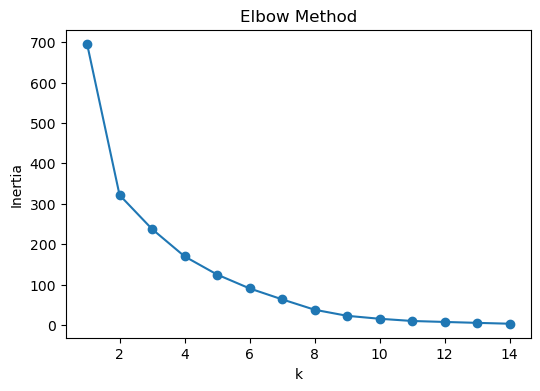

In [13]:
#Plot elbow method
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k, n_init=50, max_iter=100)
    km.fit(tcevtnocslatlon)
    sse.append([k, km.inertia_])
    
elbow_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})

plt.figure(figsize=(6,4))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [14]:
# Choose cluster number
n_clust = 2

#K means clustering
kmeans_scale = KMeans(n_clusters=n_clust,
                      n_init=50, max_iter=100, 
                      init='k-means++')
kmeans_scale.fit(tcevtnocslatlon)

labels_scale = kmeans_scale.labels_
tcevtnocslatlon['clusters']=labels_scale

In [16]:
datav925 = xr.open_mfdataset('v925\*.nc',combine = 'by_coords')
datau925 = xr.open_mfdataset('u925\*.nc',combine = 'by_coords')
datamslp = xr.open_mfdataset('mslp\*.nc',combine = 'by_coords')

In [17]:
v925=datav925['v'].rolling(time=3, center=True).mean().sel(time=datav925.time.dt.season=="DJF").sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
u925=datau925['u'].rolling(time=3, center=True).mean().sel(time=datau925.time.dt.season=="DJF").sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
mslp=datamslp['msl'].rolling(time=3, center=True).mean().sel(time=datamslp.time.dt.season=="DJF").sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))/100
v925nm=datav925['v'].rolling(time=3, center=True).mean().sel(time=datav925.time.dt.month.isin([1, 2, 3, 11, 12])).sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000'))
u925nm=datau925['u'].rolling(time=3, center=True).mean().sel(time=datau925.time.dt.month.isin([1, 2, 3, 11, 12])).sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000'))
mslpnm=datamslp['msl'].rolling(time=3, center=True).mean().sel(time=datamslp.time.dt.month.isin([1, 2, 3, 11, 12])).sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000'))/100
climv925 = v925.mean('time')
anv925djf = v925nm - climv925
climu925 = u925.mean('time')
anu925djf = u925nm - climu925
climslp = mslp.mean('time')
anslpdjf = mslpnm - climslp
lat=anv925djf['lat'].values
lon=anv925djf['lon'].values

In [18]:
v925djfclim= anv925djf.load()
u925djfclim= anu925djf.load()
slpdjfclim= anslpdjf.load()

In [19]:
def bootstrap_3dxr(data, sample_size, n_samples, percentile):
    
    # create a list for sample means
    sample_means = []
    
    # loop n_samples times
    for i in tqdm(range(n_samples)):
        t=data.time
        trand=np.random.choice(t, size=sample_size, replace=False)
        datarandmean=data.sel(time=np.in1d(data.time,trand)).mean(dim='time')
        sample_means.append(datarandmean.values)
        
    low=np.percentile(sample_means,percentile/2, axis=0)
    high=np.percentile(sample_means,100-percentile/2, axis=0)
    
    return low, high #2D low and high threshold

In [20]:
sigmslp=np.empty([2, len(lat), len(lon)], dtype='bool')
data=slpdjfclim.sel(time=slpdjfclim.time.dt.season=="DJF")
for c in [1,0]:
    low, high = bootstrap_3dxr(data, len(tcevtnocslatlon[tcevtnocslatlon['clusters']==c].index.values), 1000, 1)
    compositemean=slpdjfclim.sel(time=np.in1d(slpdjfclim.time, tcevtnocslatlon[tcevtnocslatlon['clusters']==c].index.values)).mean(dim='time')
    sigmslp[c]=np.logical_or(compositemean<low, compositemean>high).values

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.82it/s]


In [21]:
sigu925=np.empty([2, len(lat), len(lon)], dtype='bool')
data=u925djfclim.sel(time=u925djfclim.time.dt.season=="DJF")
for c in [1,0]:
    low, high = bootstrap_3dxr(data, len(tcevtnocslatlon[tcevtnocslatlon['clusters']==c].index.values), 1000, 1)
    compositemean=u925djfclim.sel(time=np.in1d(u925djfclim.time, tcevtnocslatlon[tcevtnocslatlon['clusters']==c].index.values)).mean(dim='time')
    sigu925[c]=np.logical_or(compositemean<low, compositemean>high).values

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.95it/s]


In [22]:
sigv925=np.empty([2, len(lat), len(lon)], dtype='bool')
data=v925djfclim.sel(time=v925djfclim.time.dt.season=="DJF")
for c in [1,0]:
    low, high = bootstrap_3dxr(data, len(tcevtnocslatlon[tcevtnocslatlon['clusters']==c].index.values), 1000, 1)
    compositemean=v925djfclim.sel(time=np.in1d(v925djfclim.time, tcevtnocslatlon[tcevtnocslatlon['clusters']==c].index.values)).mean(dim='time')
    sigv925[c]=np.logical_or(compositemean<low, compositemean>high).values

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


In [23]:
siguv925=np.logical_or(sigu925, sigv925)
siguv925=siguv925.astype(float)
siguv925[siguv925==0] = np.nan

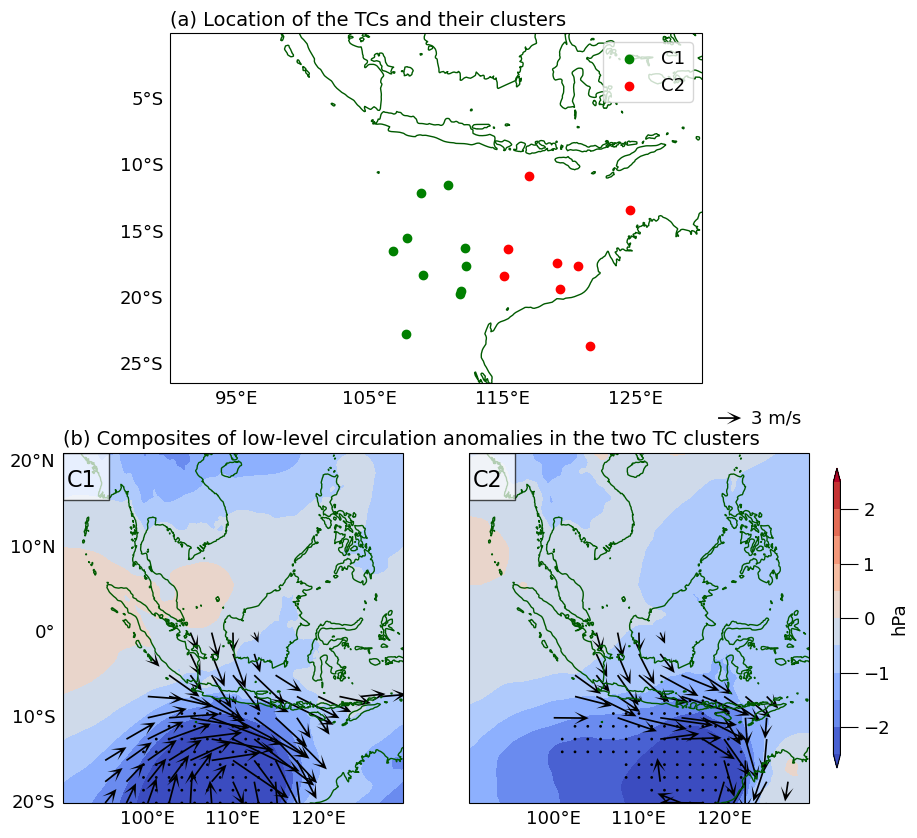

In [26]:
fig=plt.figure(figsize=(10,10))

#Plot cluster location
ax1 = fig.add_subplot(211,projection=ccrs.PlateCarree())
ax1.set_extent([90, 130, -25, 0])
gl=ax1.gridlines(draw_labels=True,linewidth=0)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}
gl.xlocator = tk.FixedLocator(np.arange(95,126,10))
ax1.scatter(tcevtnocslatlon[tcevtnocslatlon['clusters']==1]['LON'],tcevtnocslatlon[tcevtnocslatlon['clusters']==1]['LAT'],c='g', marker='o', label ='C1')
ax1.scatter(tcevtnocslatlon[tcevtnocslatlon['clusters']==0]['LON'],tcevtnocslatlon[tcevtnocslatlon['clusters']==0]['LAT'],c='r', marker='o', label ='C2')
ax1.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
ax1.set_title('(a) Location of the TCs and their clusters', loc='left', fontsize=14)
plt.legend(prop={'size': 13})

#Plot composite for each cluster
for k,c in zip(range(2),[1,0]):
        numfig=int(200+20+k+3)
        axs = fig.add_subplot(numfig,projection=ccrs.PlateCarree())
        axs.set_extent([90, 130, -19, 20])
        gl=axs.gridlines(draw_labels=True,linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = tk.FixedLocator([100, 110, 120])
        gl.xlabel_style = {'size': 13}
        gl.ylabel_style = {'size': 13}
        if k>0:
            gl.left_labels = False
        valuetp=slpdjfclim.sel(time=np.in1d(slpdjfclim.time, tcevtnocslatlon[tcevtnocslatlon['clusters']==c].index.values)).mean(dim='time')
        plotvaltp=axs.contourf(lon, lat, valuetp, transform=ccrs.PlateCarree(),
                  cmap='coolwarm',
                  levels=np.arange(-2.5, 2.6, 0.5), extend='both'
                  )
        x,y=np.meshgrid(lon, lat)
        skipp=6
        axs.scatter(x[::skipp,::skipp],y[::skipp,::skipp],sigmslp[c][::skipp,::skipp]*1,color='k', linewidth=1)
        uu=u925djfclim.sel(time=np.in1d(u925djfclim.time, tcevtnocslatlon[tcevtnocslatlon['clusters']==c].index.values)).mean(dim='time')
        vv=v925djfclim.sel(time=np.in1d(v925djfclim.time, tcevtnocslatlon[tcevtnocslatlon['clusters']==c].index.values)).mean(dim='time')
        skip = 10
        Qwd=axs.quiver(x[::skip, ::skip], y[::skip, ::skip], uu[::skip, ::skip]*siguv925[c][::skip, ::skip], vv[::skip, ::skip]*siguv925[c][::skip, ::skip], color='k', scale=13 ,scale_units='inches', width=0.005, headlength=8.5, headwidth=7.5, headaxislength=4)
        axs.add_feature(cfeature.COASTLINE, edgecolor='#005a00', zorder=1)
        if k==0:
            axs.set_title('(b) Composites of low-level circulation anomalies in the two TC clusters', loc='left', fontsize=14)
        longitude1, latitude1 = 90, 15.6
        longitude2, latitude2 = 95.5, 21.1
        axs.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                        facecolor='white', edgecolor='k', linewidth=1, alpha=0.7,
                                        transform=ccrs.PlateCarree()))
        axs.text(90.5,17.1,'C'+str(k+1),fontsize=16, c='k')
cbar_tp = fig.add_axes([0.91, 0.145, 0.007, 0.3])
cbartp = fig.colorbar(plotvaltp, cax=cbar_tp)
cbartp.ax.tick_params(labelsize=13, size=13)
cbartp.ax.set_ylabel('hPa', fontsize=13, labelpad=0)

fig.subplots_adjust(wspace=0.2, hspace=0)
qk = plt.quiverkey(Qwd, 
                  0.8, 1.1,                  
                  3,str(3)+' m/s',   
                  labelpos='E',               
                  coordinates='axes', fontproperties={'size':13}
                   )


fig.subplots_adjust(wspace=0.1, hspace=0.2)
plt.savefig('figure_output\Fig 10.pdf', bbox_inches='tight')
plt.show()